# Exercise 1.4

## Classification of CIFAR10 images
### Optimizers
In this exercise we will classify the images from the CIFAR10 dataset. We will use different optimizers and compare their convergence speed. First we import the libraries that we need.

**NB! The exercise is formulated in a Jupyter notebook for ease of communication, but you should feel *very* free to carry out the entire exercise without the notebook. If you do carry it out in a notebook, please finish by migrating your code over to a script that you can run from the terminal**

In [66]:
import numpy as np
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

We always check that we are running on a GPU

In [6]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator


In this exercise we will classify images from the [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. 
CIFAR10 has 60000 colour images of size 32x32 equally distributed in 10 classes.
* You should load this dataset (hint: it is a built-in dataset in pytorch).

In [3]:
batch_size = 64
trainset = datasets.CIFAR10("./data", train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = datasets.CIFAR10("./data", train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [80]:
len(train_loader.dataset)

50000

* Make a CNN to train on the CIFAR10 dataset

In [54]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.convolutional = nn.Sequential(
                nn.Conv2d(3, 8, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv2d(8, 8, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),
                nn.Conv2d(8, 16, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv2d(16, 16, kernel_size=3, padding=1),
                nn.ReLU()
                )

        self.fully_connected = nn.Sequential(
                nn.Linear(16 * 16 * 16, 500),
                nn.ReLU(),
                nn.Linear(500, 10),
                )

    def forward(self, x):
        x = self.convolutional(x)
        #reshape x so it becomes flat, except for the first dimension (which is the minibatch)
        x = x.view(x.size(0), -1)
        x = self.fully_connected(x)
        return x

In [62]:
model = Network()
model.to(device)
#Initialize the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)


def conv_output_dim(model: nn.Module, data_sample: torch.Tensor) -> int:
    return model.convolutional(data_sample).shape
data = next(iter(train_loader))[0].to(device)
arr = conv_output_dim(model, data[0])
print(f"Dimension of output: {arr}, total output shape: {np.product(arr)}")

Dimension of output: torch.Size([16, 16, 16]), total output shape: 4096


In [70]:
#We define the training as a function so we can easily re-use it.
def train(model, optimizer, num_epochs=10):
    def loss_fun(output, target):
        return F.nll_loss(F.log_softmax(output, dim=1), target)
    out_dict = {'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}
  
    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #Compute the loss
            loss = loss_fun(output, target)
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            train_loss.append(loss.item())
            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()
        #Comput the test accuracy
        test_loss = []
        test_correct = 0
        model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
            test_loss.append(loss_fun(output, target).cpu().item())
            predicted = output.argmax(1)
            test_correct += (target==predicted).sum().cpu().item()
        out_dict['train_acc'].append(train_correct/len(trainset))
        out_dict['test_acc'].append(test_correct/len(testset))
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['test_loss'].append(np.mean(test_loss))
        print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
              f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")
    return out_dict

 * Train the network and plot make a plot of the loss and accuracy for both training and with the epoch on the x-axis

In [71]:
out_dict = train(model, optimizer)

  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.351	 test: 1.346	 Accuracy train: 51.8%	 test: 51.6%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.149	 test: 1.496	 Accuracy train: 59.3%	 test: 48.5%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.964	 test: 1.334	 Accuracy train: 65.6%	 test: 54.3%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.759	 test: 1.196	 Accuracy train: 73.3%	 test: 60.8%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.547	 test: 1.935	 Accuracy train: 80.9%	 test: 50.5%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.365	 test: 1.539	 Accuracy train: 87.1%	 test: 57.6%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.258	 test: 2.109	 Accuracy train: 91.1%	 test: 57.0%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.198	 test: 2.211	 Accuracy train: 93.3%	 test: 58.0%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.138	 test: 2.173	 Accuracy train: 95.4%	 test: 58.8%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.124	 test: 2.410	 Accuracy train: 95.9%	 test: 58.7%


In [28]:
out_dict.keys()

dict_keys(['train_acc', 'test_acc', 'train_loss', 'test_loss'])

Text(0, 0.5, 'Accuracy')

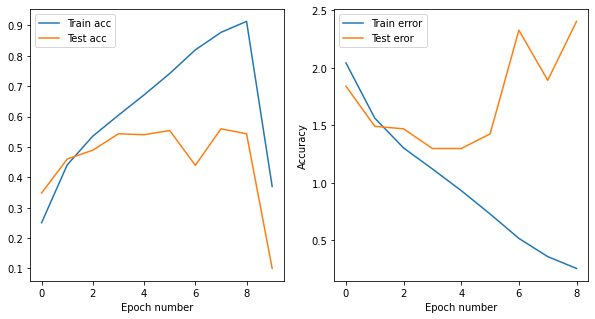

In [38]:
_, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(out_dict['train_acc'])
ax1.plot(out_dict['test_acc'])

ax2.plot(out_dict["train_loss"])
ax2.plot(out_dict["test_loss"])


ax1.legend(('Train acc','Test acc'))
ax2.legend(('Train error','Test eror'))
ax1.set_xlabel('Epoch number')
ax2.set_xlabel('Epoch number')
plt.ylabel('Accuracy')

* Discuss what you see. Are you overfitting to the training data? Do you not learn anything? What can you change to do better?

* Repeat the above steps but using Adam as the optimizer. Use Pytorch's defaults parameters. Do you learn faster?
* Which optimizer works best for you?
* Plot the test and test errors for both SGD and Adam in one plot
* Try adding Batch normalisation after your convolutional layers. Does it help?

## ResNet

Now you will create and train a ResNet.
* Implement the Residual block as a network below using convolutional kernel size $3\times3$ according to the figure below
![Residual block](https://cdn-images-1.medium.com/max/800/1*D0F3UitQ2l5Q0Ak-tjEdJg.png)

In [47]:
class ResNetBlock(nn.Module):
    def __init__(self, n_features):
        super(ResNetBlock, self).__init__()
        self.weight_layer = nn.Sequential(
            nn.Conv2d(n_features, n_features, 3, padding="same"),
            nn.ReLU(),
            nn.Conv2d(n_features, n_features, 3, padding="same"),
        )
        self.relu = nn.ReLU()
    def forward(self, x):
        wout = self.weight_layer(x)
        fxpx = wout + x
        out = self.relu(fxpx)
        return out

The following code is a sanity of your residual block network

In [49]:
#Sanity test of your implementation
C = 4
res_block = ResNetBlock(C)
assert(len(res_block.state_dict())==4)
for name, weight in res_block.state_dict().items():
    weight*=0
    desired_shape = {'bias': (C,), 'weight': (C, C, 3, 3)}[name.split('.')[-1]]
    assert(desired_shape==weight.shape)
x = torch.randn(32, C, 32,32)
assert(torch.abs(res_block(x)-F.relu(x)).max()==0)
print("Passed sanity check")

Passed sanity check


We define a network that uses your `ResNetBlock`

In [50]:
class ResNet(nn.Module):
    def __init__(self, n_in, n_features, num_res_blocks=3):
        super(ResNet, self).__init__()
        #First conv layers needs to output the desired number of features.
        conv_layers = [nn.Conv2d(n_in, n_features, kernel_size=3, stride=1, padding=1),
                       nn.ReLU()]
        for i in range(num_res_blocks):
            conv_layers.append(ResNetBlock(n_features))
        self.res_blocks = nn.Sequential(*conv_layers)
        self.fc = nn.Sequential(nn.Linear(32*32*n_features, 2048),
                                nn.ReLU(),
                                nn.Linear(2048, 512),
                                nn.ReLU(),
                                nn.Linear(512,10),
                                nn.Softmax(dim=1))
        
    def forward(self, x):
        x = self.res_blocks(x)
        #reshape x so it becomes flat, except for the first dimension (which is the minibatch)
        x = x.view(x.size(0), -1)
        out = self.fc(x)
        return out

Let's train our new ResNet!

In [51]:
model = ResNet(3, 8)
model.to(device)
#Initialize the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
out_dict = train(model, optimizer)

  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.952	 test: 1.632	 Accuracy train: 29.2%	 test: 40.4%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.570	 test: 1.772	 Accuracy train: 43.7%	 test: 36.0%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.371	 test: 1.371	 Accuracy train: 50.8%	 test: 50.6%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.223	 test: 1.469	 Accuracy train: 56.1%	 test: 49.1%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.069	 test: 1.466	 Accuracy train: 61.8%	 test: 50.5%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.884	 test: 1.520	 Accuracy train: 68.5%	 test: 48.8%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.656	 test: 1.690	 Accuracy train: 76.8%	 test: 51.2%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.441	 test: 1.499	 Accuracy train: 84.5%	 test: 54.4%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.257	 test: 1.999	 Accuracy train: 91.1%	 test: 56.9%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: nan	 test: nan	 Accuracy train: 14.9%	 test: 10.0%




Do you get nan loss at some point during training? 
This can be caused by the numerical instability of using softmax and log as two functions. 
* Change your network and loss to use a layer that combines the softmax log into one such as `nn.LogSoftmax`. You can also use `nn.CrossEntropyLoss` which also integrates `nn.NLLLoss`.